In [157]:
### IMPORTS
import os
import glob
#import util

import numpy as np
import pandas as pd
import random
import math
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
from torch.autograd import Variable
import torch.nn.init as init

from collections import defaultdict
from collections import Counter

from datetime import datetime

import SimpleITK as sitk

In [163]:
### useful functions

def windowImage(image, window_width, window_center, output_min=0, output_max=1):
    """Normalizes SimpleITK *image* (CT scan) based on window specification
    (example, abdominal soft tissue window is W = 400, C = 50, or -350 to 450)
    Clips values above 0 and 1
    """
    
    window_min = window_center - window_width / 2
    window_max = window_center + window_width / 2
    
    windowed_image = sitk.IntensityWindowing(image, window_min, window_max, output_min, output_max)
    
    return windowed_image

def resampleImage(image, finalsize, interpolation='linear'):
    """Resamples SimpleITK image to finalsize x finalsize (width and height in pixels)
    Preserves the original physical size of the image and number of slices
    Changes the resolution so that the new image has numslices x *finalsize x *finalsize dimensions"""
    
    size = image.GetSize()
    numslices = size[2]
    squaresize = size[1]

    # RESAMPLE TO finalsize x finalsize
    finalnpy = np.zeros([numslices, finalsize, finalsize])
    reference = sitk.GetImageFromArray(finalnpy)
    reference.SetOrigin(image.GetOrigin())
    reference.SetDirection(image.GetDirection())

    spacing = image.GetSpacing()
    newspacing = np.zeros(3)
    newspacing[0:2] = (squaresize - 1) * np.array(spacing[0:2]) / (finalsize - 1)
    newspacing[2] = spacing[2]
    reference.SetSpacing(newspacing)


    # MAKING RESAMPLING FILTER
    resample = sitk.ResampleImageFilter()
    resample.SetReferenceImage(reference)
    if interpolation == 'linear':
        resample.SetInterpolator(sitk.sitkLinear)
    elif interpolation == 'NN':
        resample.SetInterpolator(sitk.sitkNearestNeighbor)

    # RESAMPLE TO finalsize x finalsize x n
    resampledimg = resample.Execute(image)

    return resampledimg


def projectImage(reference, moving, interpolate = 'linear'):
    """Projects an SimpleITK image (*moving onto *reference)
    interpolate* = linear or NN (nearest neighbor)"""
    
    resample = sitk.ResampleImageFilter()
    resample.SetReferenceImage(reference)
    if interpolate == 'linear':
        resample.SetInterpolator(sitk.sitkLinear)
    elif interpolate == 'NN':
        resample.SetInterpolator(sitk.sitkNearestNeighbor)

    resampledimg = resample.Execute(moving)

    return resampledimg


def getNumpysFromImageAndMask(imagepath, maskpath, predpath):
    """Input is file path of image and mask nifti files (panorama)
       Output is 1. image_npy: a 3D numpy of the CT scan
             2. mask_npy: 3D numpy of the mask, projected onto the image (nearest neighbor)
             3. pred_npy: 3D numpy of the predicted segmentation, projected onto the image (nearest neighbor)
             """

    image = sitk.ReadImage(imagepath)
    mask = sitk.ReadImage(maskpath, sitk.sitkInt16)
    pred = sitk.ReadImage(predpath, sitk.sitkInt16)
    
    image = windowImage(image, window_width=400, window_center=50, output_min=0, output_max=1)
    
    projected_mask = projectImage(image, mask, interpolate = 'NN')
    projected_pred = projectImage(image, pred, interpolate = 'NN')

    image_npy = sitk.GetArrayFromImage(image)   #images are in z, y, x format
    mask_npy = sitk.GetArrayFromImage(projected_mask)
    pred_npy = sitk.GetArrayFromImage(projected_pred)
        
    return image_npy, mask_npy, pred_npy


def bbox_3D(img):
    """Finds the bounding box around a 3D image (numpy)
    returns rmin, rmax, cmin, cmax, zmin, zmax (r = row, c = column)"""
    try:    
        z = np.any(img, axis=(1, 2))    #z
        c = np.any(img, axis=(0, 1))    #x , (c = column)
        r = np.any(img, axis=(0, 2))    #y , (r = row)

        rmin, rmax = np.where(r)[0][[0, -1]]
        cmin, cmax = np.where(c)[0][[0, -1]]
        zmin, zmax = np.where(z)[0][[0, -1]]

        #x min max, y min max, z min max
        return [rmin, rmax, cmin, cmax, zmin, zmax]
    except:
        return -1, -1, -1, -1, -1, -1

def get_color_segmentation_map(zslice):
    ''' colors pancreas yellow (1 1 0) and lesion red (1 0 0)'''
    colored = np.zeros((zslice.shape[0], zslice.shape[1], 3))
    colored[:, :, 0] = ((zslice == 1) + (zslice == 2)) > 0     
    colored[:, :, 1] = zslice == 1                             

    return(colored)


def get_seg_pred_overlay(seg, pred, panc_or_lesion):
    ''' true positive: both seg and pred = green
        false positive: only prediction = blue
        false negative: only segmentation = magenta

        panc_or_lesion: 1 if panc, 2 if lesion
    '''
    seg = (seg == panc_or_lesion).astype(int)
    pred = (pred == panc_or_lesion).astype(int)
    
    TP = seg * pred
    FP = ((seg - pred) == 1)
    FN = ((pred - seg) == 1)

    colored = np.zeros((seg.shape[0], seg.shape[1], 3))

    colored[:, :, 0] = FN
    colored[:, :, 1] = TP
    colored[:, :, 2] = (FP + FN) > 0

    return(colored)

def get_color_img_overlay(img, color, alpha):
    colored_pixels = color > 0
    overlay = (1 - colored_pixels) * img + ((colored_pixels) * img * alpha + color * (1-alpha))

    return(overlay)

In [117]:
original_dir = r'C:\Users\Leo\Documents\UHN-MedImg3D-ML-quiz\validation'
subtype_folders = ['subtype0', 'subtype1', 'subtype2']
predicted_dir = r'C:\Users\Leo\Documents\UHN-MedImg3D-ML-quiz\validation_predictions\nnUnet_3d_fullres_Oct5_PP'

csv_file = 'nnUnet_3d_fullres_Oct5_dice.csv'
csv_path = os.path.join(predicted_dir, csv_file)

df = pd.read_csv(csv_path, dtype=str, index_col=0)

In [118]:
print(df)

    ID   subtype       pancreas_dice           lesion_dice
0  168  subtype0  0.8237120400142908  0.009999791671006853
0  171  subtype0  0.9258756271905928     0.776258205689278
0  174  subtype0   0.917302350502672    0.8038049940546967
0  184  subtype0  0.9530394860238232     0.929241323942634
0  187  subtype0  0.9328653548891003    0.5220651242502142
0  189  subtype0  0.9107805426013548    0.9241643081159642
0  244  subtype0  0.9333828452869336    0.5896051299358758
0  253  subtype0  0.9403098974750324    0.6022478926006869
0  254  subtype0  0.8542987792251454   0.49042830540037247
0  090  subtype1  0.8378675591680612    0.1088659793814433
0  093  subtype1  0.8181499894965338    0.8213449836167889
0  094  subtype1   0.957118612486214     0.534132662927867
0  154  subtype1  0.8953754617017365    0.5185018558092453
0  158  subtype1   0.915624024149058    0.8493939888037393
0  164  subtype1  0.8990071563668565    0.9333734313913115
0  166  subtype1  0.9369577162859798    0.92320949827652

In [276]:
#top3df = df.sort_values(by=['lesion_dice'], ascending=False).head(3)

top3df = df.sort_values(by=['lesion_dice'], ascending=True).head(8)

print(top3df)

    ID   subtype       pancreas_dice           lesion_dice
0  242  subtype1  0.9317758957453544                   0.0
0  227  subtype1  0.9478794952221169                   0.0
0  191  subtype2    0.75510801047197                   0.0
0  168  subtype0  0.8237120400142908  0.009999791671006853
0  088  subtype2  0.9237372317496018  0.014336917562724014
0  090  subtype1  0.8378675591680612    0.1088659793814433
0  080  subtype2  0.9475640056173706    0.2525334414268342
0  254  subtype0  0.8542987792251454   0.49042830540037247


In [298]:
#################

plot_figure_index = 7
slice_step = 15
alpha = 0.25   # opacity for overlays

figwidth = 7
figheight = 8

##################


def get_niftis(ID, subtype):
    nifti_name = 'quiz' + '_' + str(subtype[-1]) + '_' + str(ID) + '_0000.nii.gz'
    seg_name = 'quiz' + '_' + str(subtype[-1]) + '_' + str(ID) + '.nii.gz'
    return nifti_name, seg_name


ID = top3df.iloc[plot_figure_index]['ID']
subtype = top3df.iloc[plot_figure_index]['subtype']
pancreas_dice = round(float(top3df.iloc[plot_figure_index]['pancreas_dice']), 3)
lesion_dice = round(float(top3df.iloc[plot_figure_index]['lesion_dice']), 3)

nifti_name, seg_name = get_niftis(ID, subtype)
nifti_path = os.path.join(os.path.join(original_dir, subtype), nifti_name)
seg_path = os.path.join(os.path.join(original_dir, subtype), seg_name)

prediction_name = 'quiz_' + ID + '.nii'
prediction_path = os.path.join(predicted_dir, prediction_name)

### Load the images
img_npy, mask_npy, pred_npy = getNumpysFromImageAndMask(nifti_path, seg_path, prediction_path)

### only show slices where the segmentations or predictions exist
rmin, rmax, cmin, cmax, zmin, zmax = bbox_3D(mask_npy + pred_npy)

#rmin, rmax, cmin, cmax, zmin, zmax = bbox_3D((mask_npy == 2) + (pred_npy == 2))    # lesion only

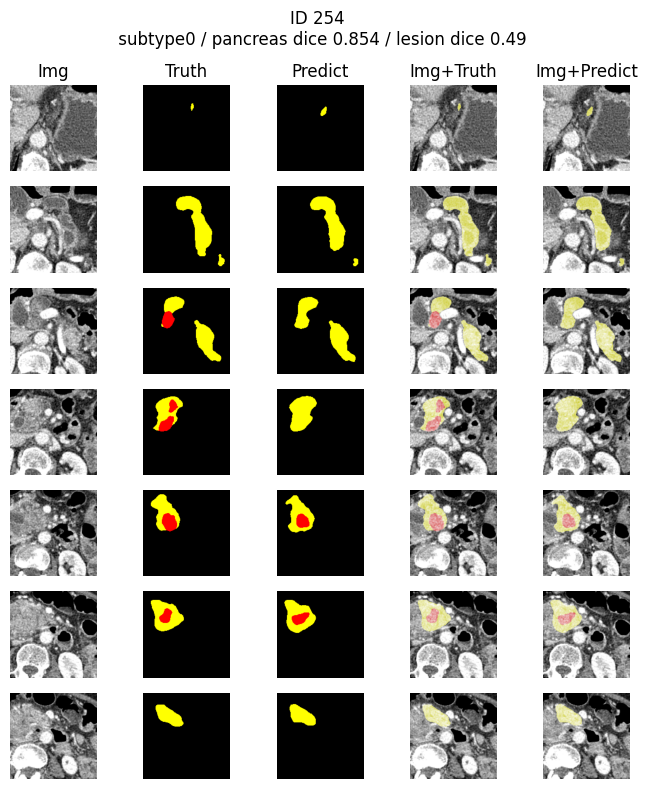

In [299]:
# generate the figure with pancreas (yellow) and lesion (red)
zslices = range(zmin, zmax, slice_step)

fig, axs = plt.subplots(nrows=len(zslices), ncols=5, figsize=(figwidth, figheight), tight_layout=True)
fig.suptitle('ID ' + ID + ' \n ' + subtype + ' / pancreas dice ' +str(pancreas_dice) + ' / lesion dice ' + str(lesion_dice))

for row, zslice in enumerate(zslices):
    img_slice = np.stack((img_npy[zslice, :, :],)*3, axis=-1)
    colored_mask = get_color_segmentation_map(mask_npy[zslice, :, :])
    colored_pred = get_color_segmentation_map(pred_npy[zslice, :, :])

    if row == 0:
        axs[row, 0].set_title('Img')
        axs[row, 1].set_title('Truth')
        axs[row, 2].set_title('Predict')
        axs[row, 3].set_title('Img+Truth')
        axs[row, 4].set_title('Img+Predict')
    
    axs[row, 0].imshow(img_slice)       # original image
    axs[row, 0].axis("off")
    
    axs[row, 1].imshow(colored_mask)    # ground truth segmentation
    axs[row, 1].axis("off")

    axs[row, 2].imshow(colored_pred)    # prediction
    axs[row, 2].axis("off")

    
    axs[row, 3].imshow(get_color_img_overlay(img_slice, colored_mask, alpha))    # ground truth segmentation + original overlay
    axs[row, 3].axis("off")
    
    
    
    axs[row, 4].imshow(get_color_img_overlay(img_slice, colored_pred, alpha))    # prediction + original overlay
    axs[row, 4].axis("off")


plt.show()


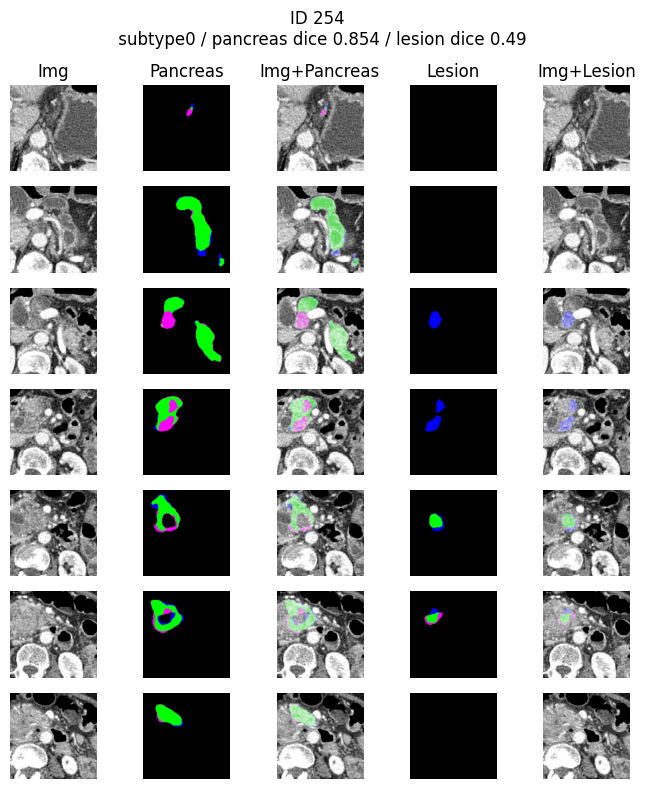

In [300]:
# generate the figure with true positive (green) and false positive (magenta) and false negative (blue)
zslices = range(zmin, zmax, slice_step)

fig, axs = plt.subplots(nrows=len(zslices), ncols=5, figsize=(figwidth, figheight), tight_layout=True)
fig.suptitle('ID ' + ID + ' \n ' + subtype + ' / pancreas dice ' +str(pancreas_dice) + ' / lesion dice ' + str(lesion_dice))

for row, zslice in enumerate(zslices):
    img_slice = np.stack((img_npy[zslice, :, :],)*3, axis=-1)
    pancreas_map = get_seg_pred_overlay(mask_npy[zslice, :, :], pred_npy[zslice, :, :], 1)
    lesion_map = get_seg_pred_overlay(mask_npy[zslice, :, :], pred_npy[zslice, :, :], 2)

    if row == 0:
        axs[row, 0].set_title('Img')
        axs[row, 1].set_title('Pancreas')
        axs[row, 2].set_title('Img+Pancreas')
        axs[row, 3].set_title('Lesion')
        axs[row, 4].set_title('Img+Lesion')
    
    axs[row, 0].imshow(img_slice)       # original image
    axs[row, 0].axis("off")
    
    axs[row, 1].imshow(pancreas_map)    # pancreas
    axs[row, 1].axis("off")

    axs[row, 2].imshow(get_color_img_overlay(img_slice, pancreas_map, alpha))    # original + pancreas
    axs[row, 2].axis("off")

    
    axs[row, 3].imshow(lesion_map)    # ground truth segmentation + original overlay
    axs[row, 3].axis("off")
    
    
    
    axs[row, 4].imshow(get_color_img_overlay(img_slice, lesion_map, alpha))    # prediction + original overlay
    axs[row, 4].axis("off")


plt.show()
